Go to [localhost:8787](the workers' monitor)

In [1]:
%matplotlib inline
import xarray as xr
import datetime
import os
import matplotlib.pyplot as plt
from dask.dot import dot_graph
import itertools
import logging
import netCDF4
import numpy as np
import numpy.ma as ma
import dask.array as da
from dask import delayed
import time
from dask.distributed import Client
from urllib import request
from multiprocessing import Pool
import glob

In [2]:
# We define some important data
client = Client('scheduler:8786')
download_location = '/temp'
data_url = 'http://nasanex.s3.amazonaws.com'
# data_url = 'http://172.21.0.1:8080'
max_download_attempts = 5
all_models = ['ACCESS1-0',  'BNU-ESM', 'CCSM4', 'CESM1-BGC', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC-ESM-CHEM', 'MIROC-ESM', 'MIROC5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M', 'bcc-csm1-1', 'inmcm4']
# all_models = ['ACCESS1-0',  'BNU-ESM']
all_vars = ['tasmax', 'pr', 'tasmin']
all_years = {
    'historical': list(range(1971, 2001))
}

year_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
year_leap_days = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]


In [6]:
# And some functions to deal with loading data into the cluster
def get_dataset_url(variable, scenario, model, year, prefix = data_url):
    prefix_filename = '/'.join([prefix, 'NEX-GDDP', 'BCSD', scenario, 'day', 'atmos', variable, 'r1i1p1', 'v1.0'])
    filename = '_'.join([variable, 'day', 'BCSD', scenario, 'r1i1p1', model, str(year) + '.nc'])
    url = '/'.join([prefix_filename, filename])
    # url = '/'.join([prefix, filename])
    return url

def get_context(year, **kwargs):
    variables = [kwargs.get('variable')] if kwargs.get('variable') else all_vars
    scenarios = ['historical']
    models = [kwargs.get('model')] if kwargs.get('model') else all_models
    outlist = []
    combinations = list(itertools.product(variables, scenarios, models))
    result = list(map(lambda comb: [ *comb, year ], combinations))
    return result

def get_year_ensemble(year, variable = 'tasmax'):
    context = get_context(year, variable = variable)
    datasets = list(map(lambda x: str(get_dataset_url(*x)), context))
    return datasets

def download_file(url):
    print("url: " + url)
    attempts = 0
    success = False
    filename = ""
    while attempts < max_download_attempts and not success:
        time.sleep(2 ** attempts)
        filename = '/'.join([download_location, str(url.split('/')[-1])])
        print("Downloading file at " + filename)
        u = request.urlopen(url)
        f = open(filename, 'wb')
        f.write(u.read())
        f.close()
        success = True
        break
    return filename

def download_file_list(url_list):
    print("Starting download pool")
    pool = Pool()
    res = pool.map(download_file, url_list)
    print("Jobs sent")
    pool.close()
    pool.join()
    print("Downloads finished")
    print(res)
    return res


def download_and_stack(year):
    tasmax_urls = list(map(lambda x: get_year_ensemble(x, variable = 'tasmax'), [year]))[0]
    print(tasmax_urls)
    tasmax_filenames = download_file_list(tasmax_urls)
    print(tasmax_filenames)
    tasmax_datasets = [ netCDF4.Dataset(filename) for filename in tasmax_filenames ]
    print(tasmax_datasets)

    tasmax_dask_arrays = []
    for dset in tasmax_datasets:
          tasmax_dask_arrays.append(da.from_array(dset['tasmax'], chunks= (366, 144, 144)))
    try:
          tasmax_final_stack = da.stack(tasmax_dask_arrays, axis = 0)
          print(tasmax_final_stack)
    except:
        return tasmax_filenames, None, None

    tasmin_urls = list(map(lambda x: get_year_ensemble(x, variable = 'tasmin'), [year]))[0]
    print(tasmin_urls)
    tasmin_filenames = download_file_list(tasmin_urls)
    print(tasmin_filenames)
    tasmin_datasets = [ netCDF4.Dataset(filename) for filename in tasmin_filenames ]
    print(tasmin_datasets)

    tasmin_dask_arrays = []
    for dset in tasmin_datasets:
          tasmin_dask_arrays.append(da.from_array(dset['tasmin'], chunks= (366, 144, 144)))
    try:
          tasmin_final_stack = da.stack(tasmin_dask_arrays, axis = 0)
          print(tasmin_final_stack)
    except:
          return [*tasmax_filenames, *tasmin_filenames], None, None

    final_stack = da.stack((tasmin_final_stack, tasmax_final_stack))
    return [*tasmax_filenames, *tasmin_filenames], final_stack

def destack(a, chunksize):
    nmodels, tasvars, time, lat, lon = a.shape
    nstacks_lat = int(np.ceil(lat / chunksize))
    nstacks_lon = int(np.ceil(lon / chunksize))
    
    stacks = []
    
    for i in range(nstacks_lat):
        for j in range(nstacks_lon):
            latmin, latmax = i * chunksize, (i+1) * chunksize
            lonmin, lonmax = j * chunksize, (j+1) * chunksize
            # print(i, j, '~>', latmin, latmax, lonmin, lonmax)
            stacked = a[:, :, :, latmin:latmax, lonmin:lonmax]
            # print(stacked)
            stacks.append(stacked)
    return stacks

def copy_dataset(src, output_filename):
    dst = netCDF4.Dataset('/home/jovyan/work/' + output_filename, "w")
    # copy attributes
    for name in src.ncattrs():
        dst.setncattr(name, src.getncattr(name))
    # copy dimensions
    for name, dimension in src.dimensions.items():
        dst.createDimension(
            name, (dimension)
        )
    dst.close()
    return output_filename

def restack(chunk_list, chunksize):
    shapes = list(map(np.shape, chunk_list))
    ndays = shapes[0][0]
    nlons = int(1440 / chunksize)
    nlats = int(720 / chunksize)
    out_array = np.empty((ndays, 720, 1440))
    combs = list(itertools.product(
        list(range(nlats)),
        list(range(nlons))
    ))
    res_list = zip(combs, chunk_list)
    for position, arr in res_list:
        minlon, maxlon = position[0] * chunksize, position[0] * chunksize + chunksize
        minlat, maxlat = position[1] * chunksize, position[1] * chunksize + chunksize
        out_array[:, minlon:maxlon, minlat:maxlat] = arr
    return out_array

def stack_from_disk(year, chunksize):
    year_ensemble_tasmin = list(map(lambda x: x.split('/')[-1], get_year_ensemble(year, variable = 'tasmin')))
    year_ensemble_tasmax = list(map(lambda x: x.split('/')[-1], get_year_ensemble(year, variable = 'tasmax')))
    datasets_tasmin = [ netCDF4.Dataset('../temp/' + filename) for filename in year_ensemble_tasmin ]
    datasets_tasmax = [ netCDF4.Dataset('../temp/' + filename) for filename in year_ensemble_tasmax ]
    das_tasmin = list(map(lambda dset: da.from_array(dset['tasmin'], chunks = (365, chunksize, chunksize)), datasets_tasmin))
    das_tasmax = list(map(lambda dset: da.from_array(dset['tasmax'], chunks = (365, chunksize, chunksize)), datasets_tasmax))
    # da.stack(list(map(lambda dset: da.from_array(dset['tasmax'], chunks = (365, 144, 144)), datasets_tasmax)))
    final_stack_tasmin = da.stack(das_tasmin)
    final_stack_tasmax = da.stack(das_tasmax)
    final_stack = da.stack((final_stack_tasmin, final_stack_tasmax))
    return final_stack

def days_to_ranges(years):
    ranges = [year_days[:i +1] for i, n in enumerate(year_days)]
    result = [(sum(element[:-1]), sum(element)) for element in ranges]
    return result

def stack_to_months(stack):
    days = days_to_ranges(year_days) if stack.shape[2] == 365 else days_to_ranges(year_leap_days)
    for period in days:
        yield(stack[:, :, period[0]:period[1], :, :])

def stack_to_models(stack):
    for model in range(stack.shape[0]):
        yield(stack[model, :, :, :])


        

In [7]:
# Ensure we have a clean client for testing
client.restart()

<Client: scheduler='tcp://172.22.0.3:8786' processes=1 cores=8>

In [8]:
# Load data to a dataset
year = 1971

print(f"Starting processing for year {str(year)}")
print(datetime.datetime.now())
print("Downloading")

# Stacking all data into the same dask dataset
# Change for download from amazon
stack_year = stack_from_disk(year, 144)
# Geographic chunking
print(stack_year)
# dask.array<stack, shape=(2, 21, 365, 720, 1440), dtype=float32, chunksize=(1, 1, 365, 360, 360)>

Starting processing for year 1971
2017-11-29 10:34:25.092788
Downloading
dask.array<stack, shape=(2, 21, 365, 720, 1440), dtype=float32, chunksize=(1, 1, 365, 144, 144)>


In [ ]:
# tasavg = np.mean(stack_year, axis = 1)
# Can't really calc this without flooding memory

In [ ]:
# Yearly indexes - we define the datasets as slices of the in-worker dataset
tasmax_stack = stack_year[:, 0, :, :, :]
tasmin_stack = stack_year[:, 1, :, :, :]

print(tasmax_stack)
print(tasmin_stack)

tasavg_stack = (tasmax_stack + tasmin_stack) / 2
print(tasavg_stack)

tasmin_per_model = list(stack_to_models(tasmin_stack))
tasmax_per_model = list(stack_to_models(tasmax_stack))
tasavg_per_model = list(stack_to_models(tasavg_stack))
print(tasavg_per_model)


In [ ]:
# Some test arrays for designing the indexes
test_array_tasavg = tasavg_per_model[0].compute()
test_array_tasmax = tasmax_per_model[0].compute()
test_array_tasmin = tasmin_per_model[0].compute()
print('OK')

In [10]:
# We load the temperature baseline from a numpy array in disk
baseline = np.load('/temp/baseline_tasmax_99p.npy')
client.scatter(baseline)

# And define the functions to be applied over each dataset
# This if for a single year, either one of the variables or the
# tasavg stack, which would be calculated on-the-fly

# Heating Degree Days - in C, transformation to F should not be problematic
def hdd(a, axis):
    a_to_baseline = 291.483 - a
    masked = ma.masked_where(a_to_baseline <= 0, a_to_baseline)
    intermediate_matrix = ma.filled(masked, fill_value = 0)
    result = np.sum(intermediate_matrix, axis = 0)
    return result

# Cooling degree days
def cdd(a, axis):
    a_to_baseline = 291.483 - a
    a_to_baseline[a_to_baseline < -10000] = 0
    masked = ma.masked_where(a_to_baseline >= 0, a_to_baseline)
    intermediate_matrix = ma.filled(masked, fill_value = 0)
    result = np.sum(np.abs(intermediate_matrix), axis = 0)
    return result

# Number of days of the year with tasmax > 99 percentile from baseline 1971-2000
def extreme_heat(a, axis):
    a_to_baseline = a - baseline
    masked = ma.masked_where(a_to_baseline <= 0, a_to_baseline)
    intermediate_matrix = ma.filled(masked, fill_value = 0)
    result = np.count_nonzero(intermediate_matrix, axis = axis)
    return result

# Helper function, not to be applied directly on the worker
def longest_streak(diff):
    result = 0
    try:
        result =  np.amax(
            np.array(np.where(diff < 0)) - np.array(np.where(diff > 0))
        )
    except ValueError:
        #raised if empty
        result = 0
    return result

# Longest streak of days over freezing temperature (tasmin)
def frost_free_season(a, axis):
    # First, dealing with the first matrix
    frost_days_matrix = (a > 273.15) * 1
    # We pad it with zeroes at the ends of the designed axis
    zeros_shape = list(a.shape)
    del zeros_shape[axis]
    zeros_matrix = np.expand_dims(np.zeros(zeros_shape), axis = axis)
    concat_matrix = np.concatenate((zeros_matrix, frost_days_matrix, zeros_matrix))
    # We calculate the deltas along an axis
    diff = np.diff(concat_matrix, axis = axis)
    # And get the longest streak from there --
    # apply along axis is far from ideal, but
    # np.where doesn't operate over axes, so we have to iterate
    result = np.apply_along_axis(longest_streak, axis, diff)
    return result

In [ ]:
test_hdd_result = hdd(test_array_tasavg, axis = 0)
plt.figure(figsize=(20, 10))
plt.imshow(test_hdd_result, origin='lower')
plt.colorbar()

In [ ]:
test_cdd_result = cdd(test_array_tasavg, axis = 0)
plt.figure(figsize=(20, 10))
plt.imshow(test_cdd_result, origin='lower')
plt.colorbar()

In [ ]:
test_ff_result = frost_free_season(test_array_tasmin, axis = 0)
plt.figure(figsize=(20, 10))
plt.imshow(test_ff_result, origin='lower')
plt.colorbar()

In [ ]:
test_xh_result = extreme_heat(test_array_tasmax, axis = 0)
plt.figure(figsize=(20, 10))
plt.imshow(test_xh_result, origin='lower')
plt.colorbar()

In [ ]:
hdds_per_model = list(map(lambda arr: delayed(hdd)(arr, axis=0).compute(), tasavg_per_model))   
hdds_final_stack = np.stack(hdds_per_model)
hdds_final_result = np.stack((
    np.mean(hdds_final_stack, axis = 0),
    np.percentile(hdds_final_stack, q = 25, axis = 0),
    np.percentile(hdds_final_stack, q = 75, axis = 0)
))
cdds_per_model = list(map(lambda arr: delayed(cdd)(arr, axis=0).compute(), tasavg_per_model))   
cdds_final_stack = np.stack(cdds_per_model)
cdds_final_result = np.stack((
    np.mean(cdds_final_stack, axis = 0),
    np.percentile(cdds_final_stack, q = 25, axis = 0),
    np.percentile(cdds_final_stack, q = 75, axis = 0)
))
ffs_per_model = list(map(lambda arr: delayed(frost_free_season)(arr, axis=0).compute(), tasmin_per_model))
ffs_final_stack = np.stack(ffs_per_model)
ffs_final_result = np.stack((
    np.mean(ffs_final_stack, axis = 0),
    np.percentile(ffs_final_stack, q = 25, axis = 0),
    np.percentile(ffs_final_stack, q = 75, axis = 0)
))
xs_per_model = list(map(lambda arr: delayed(extreme_heat)(arr, axis=0).compute(), tasmax_per_model))
xs_final_stack = np.stack(xs_per_model)
xs_final_result = np.stack((
    np.mean(xs_final_stack, axis = 0),
    np.percentile(xs_final_stack, q = 25, axis = 0),
    np.percentile(xs_final_stack, q = 75, axis = 0)
))

In [ ]:
year

In [ ]:
month_stacks = list(stack_to_months(stack_year))
print("Processing monthly information")
for i, month in enumerate(month_stacks):
    print("Processing month")
    # Processing temperatures
    # Tasmin
    tasmin_arr = month[:, 0, :, :, :]
    # tasmin_arr.shape: (21, 31, 720, 1440)    
    # In this case this axis corresponds to days
    base_tasmin_mean = np.mean(tasmin_arr, axis = 1)
    # So we first compute an average across days of the month, per mode
    # And the mean and percentile per model
    tasmin_avg = np.mean(base_tasmin_mean, axis = 0).compute()
    tasmin_p75 = np.percentile(base_tasmin_mean, 75, axis = 0)
    tasmin_p25 = np.percentile(base_tasmin_mean, 25, axis = 0)

    tasmin_monthly_results = np.stack((
        tasmin_avg,
        tasmin_p25,
        tasmin_p75
    ))    
    np.save(f"/temp/tasmin_results_{year}_{i + 1}.npy", tasmin_monthly_results)


In [ ]:
    # Tasmax
    tasmax_arr = month[:, 1, :, :, :]
    # print(f"tasmax_arr.shape: {tasmax_arr.shape}")

    # base_tasmax_mean = np.mean(tasmax_arr, axis = 1)
    # tasmax_avg = np.mean(base_tasmax_mean, axis = 0).compute()
    # print(tasmax_avg.shape)
    # tasmax_p75 = np.percentile(base_tasmax_mean, 75, axis = 0)
    # print(tasmax_avg.shape)
    # tasmax_p25 = np.percentile(base_tasmax_mean, 25, axis = 0)
    # print(tasmax_avg.shape)

    # tasavg_arr = (tasmin_arr + tasmax_arr) / 2
    # print(tasavg_arr)
    # base_tasavg_mean = np.mean(tasavg_arr, axis = 0)
    # print(base_tasavg_mean)
    # tasavg_avg = np.mean(base_tasavg_mean, axis = 0).compute()
    # print(tasavg_avg.shape)
    # tasavg_p75 = np.percentile(base_tasavg_mean, 75, axis = 0)
    # print(tasavg_p75.shape)
    # tasavg_p25 = np.percentile(base_tasavg_mean, 25, axis = 0)
    # print(tasavg_p25.shape)

In [11]:
for year in all_years['historical']:
    # stack_year = download_and_stack(year)
    stack_year = stack_from_disk(year, 360)
    # dask.array<stack, shape=(2, 21, 365, 720, 1440), dtype=float32, chunksize=(1, 1, 365, 360, 360)>
    print(stack_year)
    tasmax_stack = stack_year[0, :, :, :, :]
    tasmin_stack = stack_year[1, :, :, :, :]
    tasavg_stack = (tasmax_stack + tasmin_stack) / 2
    tasmin_per_model = list(stack_to_models(tasmin_stack))
    tasmax_per_model = list(stack_to_models(tasmax_stack))
    tasavg_per_model = list(stack_to_models(tasavg_stack))

    baseline = np.load('/temp/baseline_tasmax_99p.npy')
    client.scatter(baseline)

    hdds_per_model = list(map(lambda arr: delayed(hdd)(arr, axis=0).compute(), tasavg_per_model))   
    hdds_final_stack = np.stack(hdds_per_model)
    hdds_final_result = np.stack((
        np.mean(hdds_final_stack, axis = 0),
        np.percentile(hdds_final_stack, q = 25, axis = 0),
        np.percentile(hdds_final_stack, q = 75, axis = 0)
    ))
    cdds_per_model = list(map(lambda arr: delayed(cdd)(arr, axis=0).compute(), tasavg_per_model))   
    cdds_final_stack = np.stack(cdds_per_model)
    cdds_final_result = np.stack((
        np.mean(cdds_final_stack, axis = 0),
        np.percentile(cdds_final_stack, q = 25, axis = 0),
        np.percentile(cdds_final_stack, q = 75, axis = 0)
    ))
    ffs_per_model = list(map(lambda arr: delayed(frost_free_season)(arr, axis=0).compute(), tasmin_per_model))
    ffs_final_stack = np.stack(ffs_per_model)
    ffs_final_result = np.stack((
        np.mean(ffs_final_stack, axis = 0),
        np.percentile(ffs_final_stack, q = 25, axis = 0),
        np.percentile(ffs_final_stack, q = 75, axis = 0)
    ))
    xs_per_model = list(map(lambda arr: delayed(extreme_heat)(arr, axis=0).compute(), tasmax_per_model))
    xs_final_stack = np.stack(xs_per_model)
    xs_final_result = np.stack((
        np.mean(xs_final_stack, axis = 0),
        np.percentile(xs_final_stack, q = 25, axis = 0),
        np.percentile(xs_final_stack, q = 75, axis = 0)
    ))

    totals = np.stack((hdds_per_model, cdds_per_model, ffs_per_model, xs_per_model))
    
    np.save(f"/temp/{year}_annual_temperature_measures.npy", totals)

dask.array<stack, shape=(2, 21, 365, 720, 1440), dtype=float32, chunksize=(1, 1, 365, 360, 360)>


NameError: name 'numpy' is not defined

In [28]:
for year in all_years['historical']:
    # stack_year = download_and_stack(year)
    stack_year = stack_from_disk(year, 360)
    # dask.array<stack, shape=(2, 21, 365, 720, 1440), dtype=float32, chunksize=(1, 1, 365, 360, 360)>
    print(stack_year)
    tasmax_stack = stack_year[0, :, :, :, :]
    tasmin_stack = stack_year[1, :, :, :, :]
    tasavg_stack = (tasmax_stack + tasmin_stack) / 2
    tasmin_per_model = list(stack_to_models(tasmin_stack))
    tasmax_per_model = list(stack_to_models(tasmax_stack))
    tasavg_per_model = list(stack_to_models(tasavg_stack))

    baseline = np.load('/temp/baseline_tasmax_99p.npy')
    client.scatter(baseline)

    hdds_per_model = list(map(lambda arr: delayed(hdd)(arr, axis=0).compute(), tasavg_per_model))
    for model_name, result in zip(all_models, hdds_per_model):
        np.save(f"/temp/hdds_model_{model_name}_{year}.npy", result)

    cdds_per_model = list(map(lambda arr: delayed(cdd)(arr, axis=0).compute(), tasavg_per_model))
    for model_name, result in zip(all_models, cdds_per_model):
        np.save(f"/temp/cdds_model_{model_name}_{year}.npy", result)

    ffs_per_model = list(map(lambda arr: delayed(frost_free_season)(arr, axis=0).compute(), tasmin_per_model))
    for model_name, result in zip(all_models, ffs_per_model):
        np.save(f"/temp/ffs_model_{model_name}_{year}.npy", result)

    xh_per_model = list(map(lambda arr: delayed(extreme_heat)(arr, axis=0).compute(), tasmax_per_model))
    for model_name, result in zip(all_models, xh_per_model):
        np.save(f"/temp/xh_model_{model_name}_{year}.npy", result)

    # hdds_final_result = np.stack((
    #     np.mean(hdds_final_stack, axis = 0),
    #     np.percentile(hdds_final_stack, q = 25, axis = 0),
    #     np.percentile(hdds_final_stack, q = 75, axis = 0)
    # ))

    # cdds_per_model = list(map(lambda arr: delayed(cdd)(arr, axis=0).compute(), tasavg_per_model))   
    # cdds_final_stack = np.stack(cdds_per_model)

    # cdds_final_result = np.stack((
    #     np.mean(cdds_final_stack, axis = 0),
    #     np.percentile(cdds_final_stack, q = 25, axis = 0),
    #     np.percentile(cdds_final_stack, q = 75, axis = 0)
    # ))
    
    # ffs_per_model = list(map(lambda arr: delayed(frost_free_season)(arr, axis=0).compute(), tasmin_per_model))
    # ffs_final_stack = np.stack(ffs_per_model)
    
    # ffs_final_result = np.stack((
    #     np.mean(ffs_final_stack, axis = 0),
    #     np.percentile(ffs_final_stack, q = 25, axis = 0),
    #     np.percentile(ffs_final_stack, q = 75, axis = 0)
    # ))
    # xs_per_model = list(map(lambda arr: delayed(extreme_heat)(arr, axis=0).compute(), tasmax_per_model))
    # xs_final_stack = np.stack(xs_per_model)
    # xs_final_result = np.stack((
    #     np.mean(xs_final_stack, axis = 0),
    #     np.percentile(xs_final_stack, q = 25, axis = 0),
    #     np.percentile(xs_final_stack, q = 75, axis = 0)
    # ))

    # totals = np.stack((hdds_per_model, cdds_per_model, ffs_per_model, xs_per_model))
    
    # np.save(f"/temp/{year}_annual_temperature_measures.npy", totals)

dask.array<stack, shape=(2, 21, 365, 720, 1440), dtype=float32, chunksize=(1, 1, 365, 360, 360)>


FileNotFoundError: [Errno 2] No such file or directory: b'../temp/tasmin_day_BCSD_historical_r1i1p1_ACCESS1-0_1972.nc'

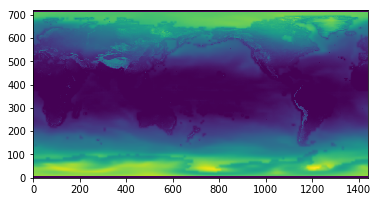

In [26]:
test_model = plt.imshow(np.load('/temp/hdds_model_bcc-csm1-1_1971.npy'), origin='lower')

In [30]:
ls -lh /temp

total 20G
-rw-rw-r-- 1 jovyan  1000 8.0M Nov 28 15:01 baseline_tasmax_99p.npy
-rw-r--r-- 1 jovyan users 4.0M Nov 29 14:21 cdds_model_ACCESS1-0_1971.npy
-rw-r--r-- 1 jovyan users 4.0M Nov 29 14:21 cdds_model_bcc-csm1-1_1971.npy
-rw-r--r-- 1 jovyan users 4.0M Nov 29 14:21 cdds_model_BNU-ESM_1971.npy
-rw-r--r-- 1 jovyan users 4.0M Nov 29 14:21 cdds_model_CanESM2_1971.npy
-rw-r--r-- 1 jovyan users 4.0M Nov 29 14:21 cdds_model_CCSM4_1971.npy
-rw-r--r-- 1 jovyan users 4.0M Nov 29 14:21 cdds_model_CESM1-BGC_1971.npy
-rw-r--r-- 1 jovyan users 4.0M Nov 29 14:21 cdds_model_CNRM-CM5_1971.npy
-rw-r--r-- 1 jovyan users 4.0M Nov 29 14:21 cdds_model_CSIRO-Mk3-6-0_1971.npy
-rw-r--r-- 1 jovyan users 4.0M Nov 29 14:21 cdds_model_GFDL-CM3_1971.npy
-rw-r--r-- 1 jovyan users 4.0M Nov 29 14:21 cdds_model_GFDL-ESM2G_1971.npy
-rw-r--r-- 1 jovyan users 4.0M Nov 29 14:21 cdds_model_GFDL-ESM2M_1971.npy
-rw-r--r-- 1 jovyan users 4.0M Nov 29 14:21 cdds_model_inmcm4_1971.npy
-rw-r--r-- 1 jovyan users 4.0M Nov 29 14